In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
###### NFL Draft Data collected from Pro Football Reference: https://www.pro-football-reference.com/draft/ ######
###### College Player Performance Data collected directly from NCAA: https://stats.ncaa.org/rankings/change_sport_year_div ######

###### 2024 Dradt data is updated ######
###### Still need to collect FCS data ---> Not all drafted players come from FBS schools ######
###### Need to manually inspect data for discrepencies in NCAA data and Draft data for player names ex. "Jr." suffix not always included" ######
###### Need to add conference/school to the NCAA datasets to be included as a categorical variable in the models ######



## Data Loading ##
nfl_draft_raw = pd.read_csv(r"/Users/richardcrnkovich/Desktop/MSDS Classes/MSDS 498/CSV Data/nfl_draft_2014_2024.csv")
college_passing_raw = pd.read_csv(r"/Users/richardcrnkovich/Desktop/MSDS Classes/MSDS 498/CSV Data/college_passing_data_v3.csv")
college_rushing_raw = pd.read_csv(r"/Users/richardcrnkovich/Desktop/MSDS Classes/MSDS 498/CSV Data/college_rushing_data_v3.csv")
college_receiving_raw = pd.read_csv(r"/Users/richardcrnkovich/Desktop/MSDS Classes/MSDS 498/CSV Data/college_receiving_data_v3.csv")

# display(nfl_draft_raw)
# display(college_passing_raw)
# display(college_rushing_raw)
# display(college_receiving_raw)

In [3]:
## Re-label Conference and Division values for each player to be the most recent/last conference they played in ##

college_passing_raw['Season'] = college_passing_raw['Season'].astype(int)
college_rushing_raw['Season'] = college_rushing_raw['Season'].astype(int)
college_receiving_raw['Season'] = college_receiving_raw['Season'].astype(int)

# Group by 'Player' and get the row with maximum 'Season' for each player
max_season_index_passing = college_passing_raw.groupby('Player')['Season'].idxmax()
max_season_index_rushing = college_rushing_raw.groupby('Player')['Season'].idxmax()
max_season_index_receiving = college_receiving_raw.groupby('Player')['Season'].idxmax()

# Create a dictionary to map player names to their most recent conferences and divisions
player_conference_map_passing = college_passing_raw.loc[max_season_index_passing].set_index('Player')['Conference'].to_dict()
player_division_map_passing = college_passing_raw.loc[max_season_index_passing].set_index('Player')['Division'].to_dict()
player_power5_map_passing = college_passing_raw.loc[max_season_index_passing].set_index('Player')['Power5'].to_dict()
player_school_map_passing = college_passing_raw.loc[max_season_index_passing].set_index('Player')['School'].to_dict()

player_conference_map_rushing = college_rushing_raw.loc[max_season_index_rushing].set_index('Player')['Conference'].to_dict()
player_division_map_rushing = college_rushing_raw.loc[max_season_index_rushing].set_index('Player')['Division'].to_dict()
player_power5_map_rushing = college_rushing_raw.loc[max_season_index_rushing].set_index('Player')['Power5'].to_dict()
player_school_map_rushing = college_rushing_raw.loc[max_season_index_rushing].set_index('Player')['School'].to_dict()

player_conference_map_receiving = college_receiving_raw.loc[max_season_index_receiving].set_index('Player')['Conference'].to_dict()
player_division_map_receiving = college_receiving_raw.loc[max_season_index_receiving].set_index('Player')['Division'].to_dict()
player_power5_map_receiving = college_receiving_raw.loc[max_season_index_receiving].set_index('Player')['Power5'].to_dict()
player_school_map_receiving = college_receiving_raw.loc[max_season_index_receiving].set_index('Player')['School'].to_dict()

# Update 'Conference' and 'Division' columns based on the mapping
college_passing_raw['Conference'] = college_passing_raw['Player'].map(player_conference_map_passing)
college_passing_raw['Division'] = college_passing_raw['Player'].map(player_division_map_passing)
college_passing_raw['Power5'] = college_passing_raw['Player'].map(player_power5_map_passing)
college_passing_raw['School'] = college_passing_raw['Player'].map(player_school_map_passing)

college_rushing_raw['Conference'] = college_rushing_raw['Player'].map(player_conference_map_rushing)
college_rushing_raw['Division'] = college_rushing_raw['Player'].map(player_division_map_rushing)
college_rushing_raw['Power5'] = college_rushing_raw['Player'].map(player_power5_map_rushing)
college_rushing_raw['School'] = college_rushing_raw['Player'].map(player_school_map_rushing)

college_receiving_raw['Conference'] = college_receiving_raw['Player'].map(player_conference_map_receiving)
college_receiving_raw['Division'] = college_receiving_raw['Player'].map(player_division_map_receiving)
college_receiving_raw['Power5'] = college_receiving_raw['Player'].map(player_power5_map_receiving)
college_receiving_raw['School'] = college_receiving_raw['Player'].map(player_school_map_receiving)

# display(college_passing_raw)
# display(college_rushing_raw)
# display(college_receiving_raw)

In [4]:
## Data Preparation ##

# Establish copies #
nfl_draft = nfl_draft_raw.copy()
college_passing = college_passing_raw.copy()
college_rushing = college_rushing_raw.copy()
college_receiving = college_receiving_raw.copy()

# Remove Freshman from the 2023 season as they are not eligible for this upcoming draft (or any draft) #
# It is okay to leave Freshman in for every other season because they will have been eligible for the NFL draft at some point #
#(Freshman in 2022 -> not eligible for draft in 2022, but is eligible for draft in 2023 when they are a sophomore)#
# If I don't remove these players it will impact the results of the model (i.e. A freshman could have an awesome season, but he will still be labeled as undrafted) #
# NFL Draft rules state a player must be out of high school for at least 3 years before being eligible to be drafted, the data collected does not list Red Shirt seasons, so #
# for simplicity, I will just exclude players labeled as freshman. This is not great, but it is the only way I have currently thought of to do this #
college_passing = college_passing[~((college_passing['Season'] == 2023) & (college_passing['Cl'] == 'Fr.'))]
college_rushing = college_rushing[~((college_rushing['Season'] == 2023) & (college_rushing['Cl'] == 'Fr.'))]
college_receiving = college_receiving[~((college_receiving['Season'] == 2023) & (college_receiving['Cl'] == 'Fr.'))]

# Drop unnecessary columns from datasets #
nfl_draft = nfl_draft[['DraftYear','Pos','Pick','Player']]
college_passing = college_passing[['Player','Pos','Division','Conference','Power5','School','G','Pass Com','Pass Att','Pass Yds','Pass TD','Int']]
college_rushing = college_rushing[['Player','Pos','Division','Conference','Power5','School','G','Rush','Rush Yds','Rush TD']]
college_receiving = college_receiving[['Player','Pos','Division','Conference','Power5','School','G','Rec','Rec Yds','Rec TD']]

# Manipulate/Create new variable for each position to indicate which number at the respective position they were drafted #
quarterback_draft = nfl_draft[nfl_draft['Pos']=='QB'].copy()
quarterback_draft['position_pick_number'] = quarterback_draft.groupby('DraftYear')['Pick'].rank().astype(int)
quarterback_draft = quarterback_draft[['Player','position_pick_number']]

running_back_draft = nfl_draft[nfl_draft['Pos']=='RB'].copy()
running_back_draft['position_pick_number'] = running_back_draft.groupby('DraftYear')['Pick'].rank().astype(int)
running_back_draft = running_back_draft[['Player','position_pick_number']]

wide_receiver_draft = nfl_draft[nfl_draft['Pos']=='WR'].copy()
wide_receiver_draft['position_pick_number'] = wide_receiver_draft.groupby('DraftYear')['Pick'].rank().astype(int)
wide_receiver_draft = wide_receiver_draft[['Player','position_pick_number']]

tight_end_draft = nfl_draft[nfl_draft['Pos']=='TE'].copy()
tight_end_draft['position_pick_number'] = tight_end_draft.groupby('DraftYear')['Pick'].rank().astype(int)
tight_end_draft = tight_end_draft[['Player','position_pick_number']]

# display(college_passing)
# display(college_rushing)
# display(college_receiving)
# display(quarterback_draft)
# display(running_back_draft)
# display(wide_receiver_draft)
# display(tight_end_draft)

In [5]:
## Data Preparation ##

# Aggregate player data to get career stats instead of individual season stats #

# Quarterback Passing #
career_stats_qb_passing = college_passing.copy()
career_stats_qb_passing = career_stats_qb_passing[career_stats_qb_passing['Pos']=='QB']
career_stats_qb_passing = career_stats_qb_passing.groupby(['Player','Division','Conference','Power5','School']).sum().reset_index()
career_stats_qb_passing['Pass_Yds/Att'] = (career_stats_qb_passing['Pass Yds'] / career_stats_qb_passing['Pass Att']).round(1)
career_stats_qb_passing['Pass_Yds/G'] = (career_stats_qb_passing['Pass Yds'] / career_stats_qb_passing['G']).round(1)
career_stats_qb_passing['Pass_Com/G'] = (career_stats_qb_passing['Pass Com'] / career_stats_qb_passing['G']).round(1)
career_stats_qb_passing['Pass_TD/G'] = (career_stats_qb_passing['Pass TD'] / career_stats_qb_passing['G']).round(1)
career_stats_qb_passing['Int/G'] = (career_stats_qb_passing['Int'] / career_stats_qb_passing['G']).round(1)

# Running Back Rushing #
career_stats_rb_rushing = college_rushing.copy()
career_stats_rb_rushing = career_stats_rb_rushing[career_stats_rb_rushing['Pos']=='RB']
career_stats_rb_rushing = career_stats_rb_rushing.groupby(['Player','Division','Conference','Power5','School']).sum().reset_index()
career_stats_rb_rushing['Rush Yds/Att'] = (career_stats_rb_rushing['Rush Yds'] / career_stats_rb_rushing['Rush']).round(1)
career_stats_rb_rushing['Rush Yds/G'] = (career_stats_rb_rushing['Rush Yds'] / career_stats_rb_rushing['G']).round(1)
career_stats_rb_rushing['Rush TD/G'] = (career_stats_rb_rushing['Rush TD'] / career_stats_rb_rushing['G']).round(1)

# Wide Receiver Receiving #
career_stats_wr_receiving = college_receiving.copy()
career_stats_wr_receiving = career_stats_wr_receiving[career_stats_wr_receiving['Pos']=='WR']
career_stats_wr_receiving = career_stats_wr_receiving.groupby(['Player','Division','Conference','Power5','School']).sum().reset_index()
career_stats_wr_receiving['Rec Yds/Rec'] = (career_stats_wr_receiving['Rec Yds'] / career_stats_wr_receiving['Rec']).round(1)
career_stats_wr_receiving['Rec Yds/G'] = (career_stats_wr_receiving['Rec Yds'] / career_stats_wr_receiving['G']).round(1)
career_stats_wr_receiving['Rec TD/G'] = (career_stats_wr_receiving['Rec TD'] / career_stats_wr_receiving['G']).round(1)


# Tight End Receiving #
career_stats_te_receiving = college_receiving.copy()
career_stats_te_receiving = career_stats_te_receiving[career_stats_te_receiving['Pos']=='TE']
career_stats_te_receiving = career_stats_te_receiving.groupby(['Player','Division','Conference','Power5','School']).sum().reset_index()
career_stats_te_receiving['Rec Yds/Rec'] = (career_stats_te_receiving['Rec Yds'] / career_stats_te_receiving['Rec']).round(1)
career_stats_te_receiving['Rec Yds/G'] = (career_stats_te_receiving['Rec Yds'] / career_stats_te_receiving['G']).round(1)
career_stats_te_receiving['Rec TD/G'] = (career_stats_te_receiving['Rec TD'] / career_stats_te_receiving['G']).round(1)

# display(career_stats_qb_passing)
# display(career_stats_rb_rushing)
# display(career_stats_wr_receiving)
# display(career_stats_te_receiving)

In [6]:
## Merge Performance dataframes with Draft dataframes ##

final_qb_data = pd.merge(career_stats_qb_passing, quarterback_draft,on='Player',how='left')
final_rb_data = pd.merge(career_stats_rb_rushing, running_back_draft,on='Player',how='left')
final_wr_data = pd.merge(career_stats_wr_receiving, wide_receiver_draft,on='Player',how='left')
final_te_data = pd.merge(career_stats_te_receiving, tight_end_draft,on='Player',how='left')

# Create function to determine if a player is drafted or not #
def drafted_or_not(value):
    if np.isnan(value):
        return 'N'
    else:
        return 'Y'

# Add a new column "Drafted?" based on the condition #
final_qb_data['Drafted?'] = final_qb_data['position_pick_number'].apply(drafted_or_not)
final_rb_data['Drafted?'] = final_rb_data['position_pick_number'].apply(drafted_or_not)
final_wr_data['Drafted?'] = final_wr_data['position_pick_number'].apply(drafted_or_not)
final_te_data['Drafted?'] = final_te_data['position_pick_number'].apply(drafted_or_not)

# Fill NaN values in position_pick_number #
final_qb_data['position_pick_number'] = final_qb_data['position_pick_number'].fillna('Undrafted')
final_rb_data['position_pick_number'] = final_rb_data['position_pick_number'].fillna('Undrafted')
final_wr_data['position_pick_number'] = final_wr_data['position_pick_number'].fillna('Undrafted')
final_te_data['position_pick_number'] = final_te_data['position_pick_number'].fillna('Undrafted')

# Rearrange columns #
final_qb_data = final_qb_data[['Player','Division','Conference','Power5','School','Drafted?','position_pick_number','G','Pass Com','Pass Att','Pass Yds','Pass TD','Int','Pass_Yds/Att','Pass_Com/G','Pass_Yds/G',
                               'Pass_TD/G','Int/G']]
final_rb_data = final_rb_data[['Player','Division','Conference','Power5','School','Drafted?','position_pick_number','G','Rush','Rush Yds','Rush TD','Rush Yds/Att','Rush Yds/G','Rush TD/G']]
final_wr_data = final_wr_data[['Player','Division','Conference','Power5','School','Drafted?','position_pick_number','G','Rec','Rec Yds','Rec TD','Rec Yds/Rec','Rec Yds/G','Rec TD/G']]
final_te_data = final_te_data[['Player','Division','Conference','Power5','School','Drafted?','position_pick_number','G','Rec','Rec Yds','Rec TD','Rec Yds/Rec','Rec Yds/G','Rec TD/G']]

# These dataframes will be used to predict if a player is going to be drafted or not (binary response variable). If they are projected to be drafted, another model will be #
# used/created to predict their draft position #

# display(final_qb_data)
# display(final_rb_data)
# display(final_wr_data)
# display(final_te_data)

In [7]:
## Create Drafted only dataframes (will be used in a separate model to give predicted draft position, given that a player is projected to be drafted from the previous model) ##
qb_drafted_data = final_qb_data[final_qb_data['Drafted?']=='Y']
rb_drafted_data = final_rb_data[final_rb_data['Drafted?']=='Y']
wr_drafted_data = final_wr_data[final_wr_data['Drafted?']=='Y']
te_drafted_data = final_te_data[final_te_data['Drafted?']=='Y']

# display(qb_drafted_data)
# display(rb_drafted_data)
# display(wr_drafted_data)
# display(te_drafted_data)

In [8]:
#### Model Creation (Drafted or Undrafted?) QUARTERBACK ####

### Logistic Regression ###

# Label Encoding for 'Division' and 'Power5 columns
label_encoder = LabelEncoder()
final_qb_data['Division'] = label_encoder.fit_transform(final_qb_data['Division'])
final_qb_data['Power5'] = label_encoder.fit_transform(final_qb_data['Power5'])

# Establish X and y dataframes for the model #
X_quarterback = final_qb_data[['Power5','Division','Pass_Com/G','Pass_Yds/Att','Pass_Yds/G','Pass_TD/G','Int/G']]
y_quarterback = final_qb_data['Drafted?']
# Split the data into a training set (80%) and a testing set (20%)
X_train_quarterback, X_test_quarterback, y_train_quarterback, y_test_quarterback = train_test_split(X_quarterback, y_quarterback, test_size=0.15, random_state=23)
# Initialize the Model
model_quarterback = LogisticRegression(random_state=23, max_iter=1000000)
# Train the model on the training set
model_quarterback.fit(X_train_quarterback, y_train_quarterback)
# Make predictions on the testing set
y_pred_quarterback = model_quarterback.predict(X_test_quarterback)
# Evaluate the model
accuracy_quarterback = accuracy_score(y_test_quarterback, y_pred_quarterback)
classification_rep_quarterback = classification_report(y_test_quarterback, y_pred_quarterback)
coefficients_qb = model_quarterback.coef_
# Print the coefficients
print("Logistic Regression model Coefficients (Quarterback):")
for feature, coef in zip(X_train_quarterback.columns, coefficients_qb[0]):
    print(feature, ':', coef)
# Print the evaluation metrics
print(f'\nLogistic Regression Quarterback Model Accuracy: {accuracy_quarterback:.2f}')
print('Logistic Regression Classification Report (Quarterback):\n', classification_rep_quarterback)

### Random Forest ###

## Conduct hyperparameter tuning for n_estimators in RF Model (change the input values here based on the output to find the best value) ##
param_grid = {'n_estimators': [70,71,72,73,74,75,76,77,78,79,80,81,82,83]}  
# Initialize Random Forest Classifier for tuning
rf_classifier = RandomForestClassifier(random_state=23)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Perform hyperparameter tuning
grid_search.fit(X_quarterback, y_quarterback)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)
# Print the best accuracy score found
print("Best Accuracy:", grid_search.best_score_)

# Initialize Random Forest Classifier for final model
rf_quarterback = RandomForestClassifier(n_estimators=82, random_state=23) # n_estimators = 82 from hyperparameter tuning
# Train the model
rf_quarterback.fit(X_train_quarterback, y_train_quarterback)
# Predict on the testing set
y_pred_quarterback_rf = rf_quarterback.predict(X_test_quarterback)
# Evaluate the model and print evaluation metrics
accuracy_quarterback_rf = accuracy_score(y_test_quarterback, y_pred_quarterback_rf)
print(f'\nRandom Forest Quarterback Model Accuracy: {accuracy_quarterback_rf:.2f}')
print("Random Forest Classification Report (Quarterback):")
print(classification_report(y_test_quarterback, y_pred_quarterback_rf))

Logistic Regression model Coefficients (Quarterback):
Power5 : 1.6572684732288419
Division : -1.25851803065324
Pass_Com/G : -0.1731728017753056
Pass_Yds/Att : 0.07227131786060802
Pass_Yds/G : 0.03412332657011462
Pass_TD/G : 0.10075502470623075
Int/G : -2.3123044344536243

Logistic Regression Quarterback Model Accuracy: 0.92
Logistic Regression Classification Report (Quarterback):
               precision    recall  f1-score   support

           N       0.92      1.00      0.96       203
           Y       0.86      0.25      0.39        24

    accuracy                           0.92       227
   macro avg       0.89      0.62      0.67       227
weighted avg       0.91      0.92      0.90       227

Best Parameters: {'n_estimators': 82}
Best Accuracy: 0.9226149104976722

Random Forest Quarterback Model Accuracy: 0.92
Random Forest Classification Report (Quarterback):
              precision    recall  f1-score   support

           N       0.93      0.98      0.95       203
         

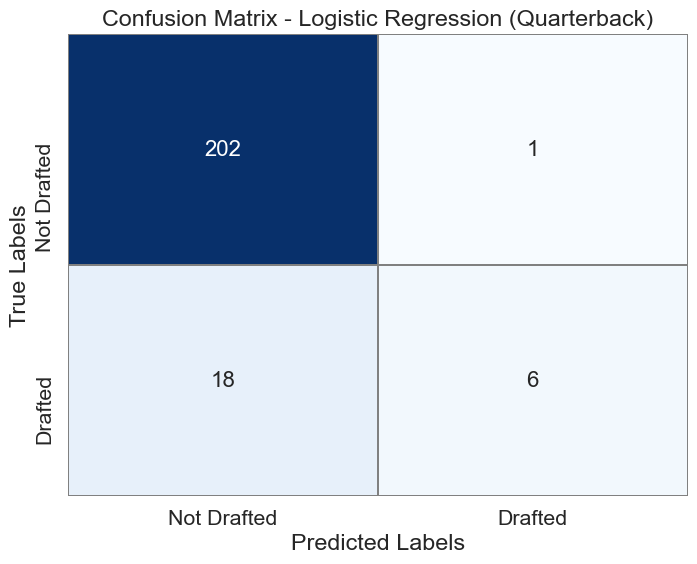

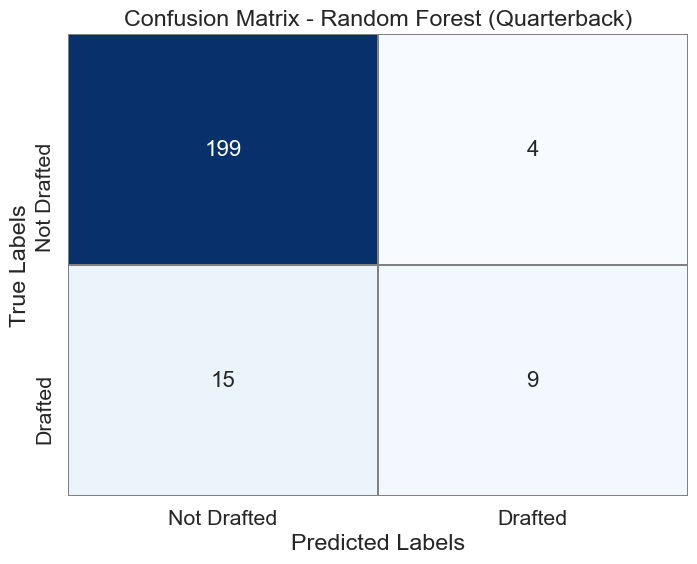

In [9]:
# Compute confusion matrix for logistic regression model
cm_lr_qb = confusion_matrix(y_test_quarterback, y_pred_quarterback)
cm_rf_qb = confusion_matrix(y_test_quarterback, y_pred_quarterback_rf)

# Plot confusion matrix for logistic regression model
class_labels = ['Not Drafted', 'Drafted']
# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_lr_qb, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (Quarterback)')
plt.show()

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_rf_qb, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Quarterback)')
plt.show()

In [10]:
#### Model Creation (Drafted or Undrafted?) RUNNING BACK ####

### Logistic Regression ###
label_encoder = LabelEncoder()
final_rb_data['Division'] = label_encoder.fit_transform(final_rb_data['Division'])
final_rb_data['Power5'] = label_encoder.fit_transform(final_rb_data['Power5'])
# Establish X and y dataframes for the model #
X_runningback = final_rb_data[['Power5','Division','Rush Yds/Att','Rush Yds/G','Rush TD/G']]
y_runningback = final_rb_data['Drafted?']
# Split the data into a training set (80%) and a testing set (20%)
X_train_runningback, X_test_runningback, y_train_runningback, y_test_runningback = train_test_split(X_runningback, y_runningback, test_size=0.2, random_state=23)
# Initialize the Model
model_runningback = LogisticRegression(random_state=23, max_iter=1000000)
# Train the model on the training set
model_runningback.fit(X_train_runningback, y_train_runningback)
# Make predictions on the testing set
y_pred_runningback = model_runningback.predict(X_test_runningback)
# Evaluate the model
accuracy_runningback = accuracy_score(y_test_runningback, y_pred_runningback)
classification_rep_runningback = classification_report(y_test_runningback, y_pred_runningback)
coefficients_rb = model_runningback.coef_
# Print the coefficients
print("Logistic Regression model Coefficients (Running Back):")
for feature, coef in zip(X_train_runningback.columns, coefficients_rb[0]):
    print(feature, ':', coef)
# Print the evaluation metrics
print(f'\nLogistic Regression Running Back Model Accuracy: {accuracy_runningback:.2f}')
print('Logistic Regression Classification Report (Running Back):\n', classification_rep_runningback)

### Random Forest ###

## Conduct hyperparameter tuning for n_estimators in RF Model (change the input values here based on the output to find the best value) ##
param_grid = {'n_estimators': [95,96,97,98,99,100,101,102,103,104,105,106]}  
# Initialize Random Forest Classifier for tuning
rf_classifier = RandomForestClassifier(random_state=23)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Perform hyperparameter tuning
grid_search.fit(X_runningback, y_runningback)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)
# Print the best accuracy score found
print("Best Accuracy:", grid_search.best_score_)

# Initialize Random Forest Classifier for final model
rf_runningback = RandomForestClassifier(n_estimators=102, random_state=23) # n_estimators = 102 from hyperparameter tuning
# Train the model
rf_runningback.fit(X_train_runningback, y_train_runningback)
# Predict on the testing set
y_pred_runningback_rf = rf_runningback.predict(X_test_runningback)
# Evaluate the model and print evaluation metrics
accuracy_runningback_rf = accuracy_score(y_test_runningback, y_pred_runningback_rf)
print(f'\nRandom Forest Running Back Model Accuracy: {accuracy_runningback_rf:.2f}')
print("Random Forest Classification Report (Running Back):")
print(classification_report(y_test_runningback, y_pred_runningback_rf))

Logistic Regression model Coefficients (Running Back):
Power5 : 1.8760962285732836
Division : -2.128216907789035
Rush Yds/Att : 0.6589792590843316
Rush Yds/G : 0.04019063447498425
Rush TD/G : 1.3129297230136276

Logistic Regression Running Back Model Accuracy: 0.92
Logistic Regression Classification Report (Running Back):
               precision    recall  f1-score   support

           N       0.93      0.98      0.95       383
           Y       0.71      0.33      0.45        45

    accuracy                           0.92       428
   macro avg       0.82      0.66      0.70       428
weighted avg       0.90      0.92      0.90       428

Best Parameters: {'n_estimators': 102}
Best Accuracy: 0.9172897196261681

Random Forest Running Back Model Accuracy: 0.90
Random Forest Classification Report (Running Back):
              precision    recall  f1-score   support

           N       0.92      0.97      0.95       383
           Y       0.57      0.29      0.38        45

    accura

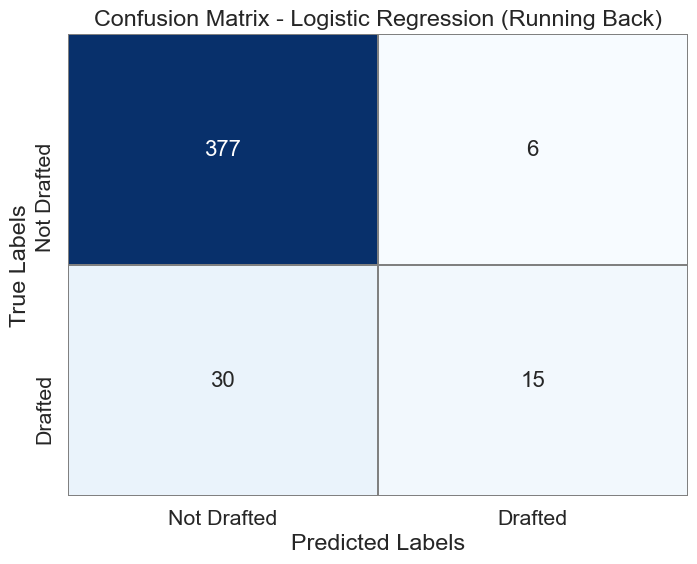

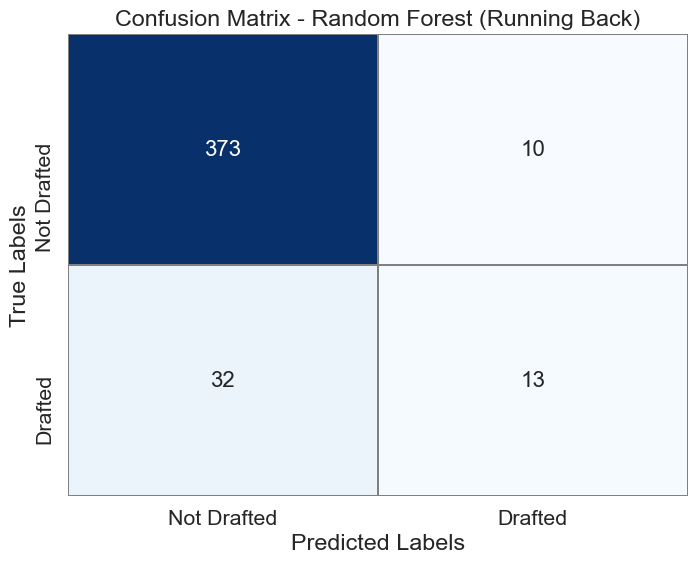

In [11]:
# Compute confusion matrix for logistic regression model
cm_lr_rb = confusion_matrix(y_test_runningback, y_pred_runningback)
cm_rf_rb = confusion_matrix(y_test_runningback, y_pred_runningback_rf)

# Plot confusion matrix for logistic regression model
class_labels = ["Not Drafted", "Drafted"]
# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_lr_rb, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (Running Back)')
plt.show()

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_rf_rb, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Running Back)')
plt.show()

In [11]:
#### Model Creation (Drafted or Undrafted?) WIDE RECEIVER ####

### Logistic Regression ###
label_encoder = LabelEncoder()
final_wr_data['Division'] = label_encoder.fit_transform(final_wr_data['Division'])
final_wr_data['Power5'] = label_encoder.fit_transform(final_wr_data['Power5'])
# Establish X and y dataframes for the model #
X_widereceiver = final_wr_data[['Division','Power5','Rec Yds/Rec','Rec Yds/G','Rec TD/G']]
y_widereceiver = final_wr_data['Drafted?']
# Split the data into a training set (80%) and a testing set (20%)
X_train_widereceiver, X_test_widereceiver, y_train_widereceiver, y_test_widereceiver = train_test_split(X_widereceiver, y_widereceiver, test_size=0.2, random_state=23)
# Initialize the Model
model_widereceiver = LogisticRegression(random_state=23, max_iter=1000000)
# Train the model on the training set
model_widereceiver.fit(X_train_widereceiver, y_train_widereceiver)
# Make predictions on the testing set
y_pred_widereceiver = model_widereceiver.predict(X_test_widereceiver)
# Evaluate the model
accuracy_widereceiver = accuracy_score(y_test_widereceiver, y_pred_widereceiver)
classification_rep_widereceiver = classification_report(y_test_widereceiver, y_pred_widereceiver)
coefficients_wr = model_widereceiver.coef_
# Print the coefficients
print("Logistic Regression model Coefficients (Wide Receiver):")
for feature, coef in zip(X_train_widereceiver.columns, coefficients_wr[0]):
    print(feature, ':', coef)
# Print the evaluation metrics
print(f'\nLogistic Regression Wide Receiver Model Accuracy: {accuracy_widereceiver:.2f}')
print('Logistic Regression Classification Report (Wide Receiver):\n', classification_rep_widereceiver)

### Random Forest ###

## Conduct hyperparameter tuning for n_estimators in RF Model (change the input values here based on the output to find the best value) ##
param_grid = {'n_estimators': [95,96,97,98,99,100,101,102,103,104,105]}  
# Initialize Random Forest Classifier for tuning
rf_classifier = RandomForestClassifier(random_state=23)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Perform hyperparameter tuning
grid_search.fit(X_widereceiver, y_widereceiver)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)
# Print the best accuracy score found
print("Best Accuracy:", grid_search.best_score_)

# Initialize Random Forest Classifier
rf_widereceiver = RandomForestClassifier(n_estimators=96, random_state=23) # n_estimators = 96 from hyperparameter tuning
# Train the model
rf_widereceiver.fit(X_train_widereceiver, y_train_widereceiver)
# Predict on the testing set
y_pred_widereceiver_rf = rf_widereceiver.predict(X_test_widereceiver)
# Evaluate the model and print evaluation metrics
accuracy_widereceiver_rf = accuracy_score(y_test_widereceiver, y_pred_widereceiver_rf)
print(f'\nRandom Forest Wide Receiver Model Accuracy: {accuracy_widereceiver_rf:.2f}')
print("Random Forest Classification Report (Wide Receiver):")
print(classification_report(y_test_widereceiver, y_pred_widereceiver_rf))

Logistic Regression model Coefficients (Wide Receiver):
Division : -2.369364834262092
Power5 : 1.4579120396517455
Rec Yds/Rec : 0.08597826198907761
Rec Yds/G : 0.04209047671749375
Rec TD/G : 2.125801385100252

Logistic Regression Wide Receiver Model Accuracy: 0.87
Logistic Regression Classification Report (Wide Receiver):
               precision    recall  f1-score   support

           N       0.88      0.98      0.93       419
           Y       0.66      0.26      0.37        74

    accuracy                           0.87       493
   macro avg       0.77      0.62      0.65       493
weighted avg       0.85      0.87      0.84       493

Best Parameters: {'n_estimators': 96}
Best Accuracy: 0.881947261663286

Random Forest Wide Receiver Model Accuracy: 0.88
Random Forest Classification Report (Wide Receiver):
              precision    recall  f1-score   support

           N       0.90      0.97      0.93       419
           Y       0.68      0.41      0.51        74

    accura

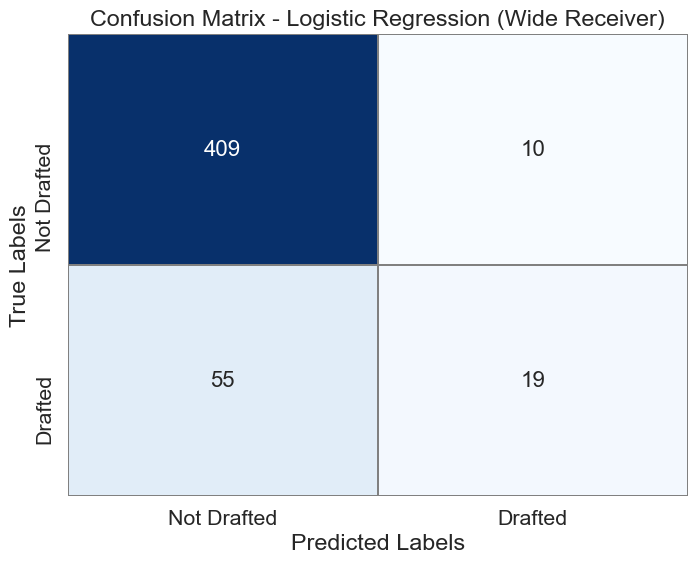

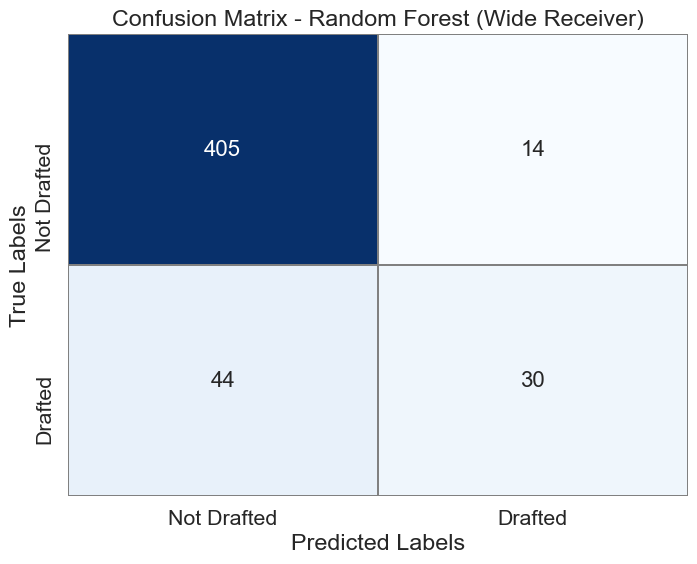

In [12]:
# Compute confusion matrix for logistic regression model
cm_lr_wr = confusion_matrix(y_test_widereceiver, y_pred_widereceiver)
cm_rf_wr = confusion_matrix(y_test_widereceiver, y_pred_widereceiver_rf)

# Plot confusion matrix for logistic regression model
class_labels = ["Not Drafted", "Drafted"]
# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_lr_wr, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (Wide Receiver)')
plt.show()

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_rf_wr, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Wide Receiver)')
plt.show()

In [15]:
#### Model Creation (Drafted or Undrafted?) TIGHT END ####

### Logistic Regression ###
label_encoder = LabelEncoder()
final_te_data['Division'] = label_encoder.fit_transform(final_te_data['Division'])
final_te_data['Power5'] = label_encoder.fit_transform(final_te_data['Power5'])
# Establish X and y dataframes for the model #
X_tightend = final_te_data[['Division','Power5','Rec Yds/Rec','Rec Yds/G','Rec TD/G']]
y_tightend = final_te_data['Drafted?']
# Split the data into a training set (80%) and a testing set (20%)
X_train_tightend, X_test_tightend, y_train_tightend, y_test_tightend = train_test_split(X_tightend, y_tightend, test_size=0.2, random_state=23)
# Initialize the Model
model_tightend = LogisticRegression(random_state=23, max_iter=1000000)
# Train the model on the training set
model_tightend.fit(X_train_tightend, y_train_tightend)
# Make predictions on the testing set
y_pred_tightend = model_tightend.predict(X_test_tightend)
# Evaluate the model
accuracy_tightend = accuracy_score(y_test_tightend, y_pred_tightend)
classification_rep_tightend = classification_report(y_test_tightend, y_pred_tightend)
coefficients_te = model_tightend.coef_
# Print the coefficients
print("Logistic Regression model Coefficients (Tight End):")
for feature, coef in zip(X_train_tightend.columns, coefficients_te[0]):
    print(feature, ':', coef)
# Print the evaluation metrics
print(f'\nLogistic Regression Tight End Model Accuracy: {accuracy_tightend:.2f}')
print('Logistic Regression Classification Report (Tight End):\n', classification_rep_tightend)

### Random Forest ###

## Conduct hyperparameter tuning for n_estimators in RF Model (change the input values here based on the output to find the best value) ##
param_grid = {'n_estimators': [170,171,172,173,174,175,176,177,178,179,180]}  
# Initialize Random Forest Classifier for tuning
rf_classifier = RandomForestClassifier(random_state=23)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
# Perform hyperparameter tuning
grid_search.fit(X_tightend, y_tightend)
# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)
# Print the best accuracy score found
print("Best Accuracy:", grid_search.best_score_)

# Initialize Random Forest Classifier
rf_tightend = RandomForestClassifier(n_estimators=171, random_state=23) # n_estimators = 171 from hyperparameter tuning
# Train the model
rf_tightend.fit(X_train_tightend, y_train_tightend)
# Predict on the testing set
y_pred_tightend_rf = rf_tightend.predict(X_test_tightend)
# Evaluate the model and print evaluation metrics
accuracy_tightend_rf = accuracy_score(y_test_tightend, y_pred_tightend_rf)
print(f'\nRandom Forest Tight End Model Accuracy: {accuracy_tightend_rf:.2f}')
print("Random Forest Classification Report (Tight End):")
print(classification_report(y_test_tightend, y_pred_tightend_rf))

Logistic Regression model Coefficients (Tight End):
Division : -1.3202300858831852
Power5 : 1.460201298158168
Rec Yds/Rec : -0.07687413813422776
Rec Yds/G : -0.0193414482889043
Rec TD/G : 0.8102257979562846

Logistic Regression Tight End Model Accuracy: 0.70
Logistic Regression Classification Report (Tight End):
               precision    recall  f1-score   support

           N       0.54      0.70      0.61        20
           Y       0.82      0.70      0.76        40

    accuracy                           0.70        60
   macro avg       0.68      0.70      0.68        60
weighted avg       0.73      0.70      0.71        60

Best Parameters: {'n_estimators': 171}
Best Accuracy: 0.7330508474576272

Random Forest Tight End Model Accuracy: 0.73
Random Forest Classification Report (Tight End):
              precision    recall  f1-score   support

           N       0.58      0.70      0.64        20
           Y       0.83      0.75      0.79        40

    accuracy              

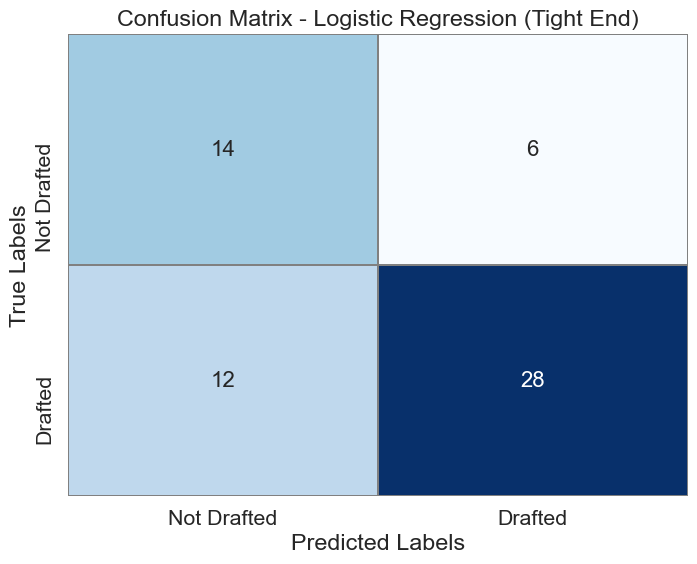

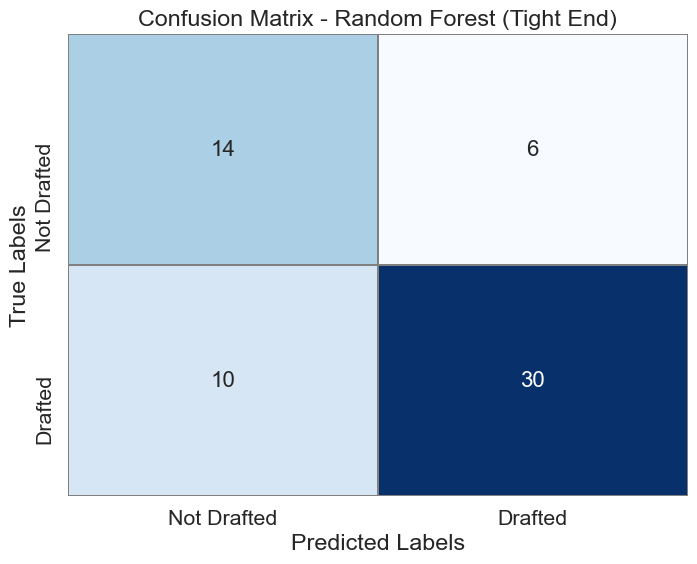

In [16]:
# Compute confusion matrix for logistic regression model
cm_lr_te = confusion_matrix(y_test_tightend, y_pred_tightend)
cm_rf_te = confusion_matrix(y_test_tightend, y_pred_tightend_rf)

# Plot confusion matrix for logistic regression model
class_labels = ["Not Drafted", "Drafted"]
# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_lr_te, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (Tight End)')
plt.show()

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4) # Adjust font size for better readability
sns.heatmap(cm_rf_te, annot=True, fmt='g', cmap='Blues', cbar=False, 
            annot_kws={"size": 16}, linewidths=0.5, linecolor='grey',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (Tight End)')
plt.show()